<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/Prepare_train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an simple PPG DNN by using labeled PPG data from Afib_Data_Clean notebook;
The loaded data is 30s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

2.1.0


#3.Prepare train, val and test data

In [0]:
#ratio value is between 0 and 1
#make sure seed is set to a same number for repeatable results\
#or to compare models apple to apple
def slice_dataset(dataset,labels,train_ratio,seed = 10):  
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  train_size = int(train_ratio * DATASET_SIZE)
  val_size = DATASET_SIZE - train_size
  
  np.random.seed(seed=seed)
  np.random.shuffle(dataset)
  train_dataset = dataset[:train_size,:,:]
  val_dataset = dataset[-val_size:,:,:]

  np.random.seed(seed=seed)
  np.random.shuffle(labels)
  train_labels = labels[:train_size,:]
  val_labels = labels[-val_size:,:]

  return train_dataset,val_dataset,train_labels, val_labels

In [0]:
#Reshape_slice_data:
#1.reshape the data from [NONE, 7500] to [NONE,ts,7500/ts,1], where 7500/ts mush be an positive integer
#2.Create train,validation and test dataset

#input:
#     ts: timesteps that define how many images/signals were fed into LSTM
#     t_ratio: test dataset ratio to (train+validation) dataset
#     val_ratio: validation dataset ratio to train dataset

#output:
#     save reshaped and shuffled dataset per 1min into train,validatin,test folders that are
#     created **BEFORE** calling this function

def reshape_slice_data(directory,ts=10,t_ratio = 0.05, val_ratio = 0.1):
  #load data
  PPG_names = glob.glob(directory + "BP_data*")
  label_names = glob.glob(directory + "BP_label*")
  
  assert(len(PPG_names) == len(label_names))

  train_labels_all = []
  val_labels_all = []
  test_labels_all = []

  for i in range(len(PPG_names)):
    if i < 59: continue
    print("processing", i, "th data")

    with open(PPG_names[i], "rb") as fp:
      raw_signals = pickle.load(fp)

    with open(label_names[i], "rb") as fp:
      raw_labels = pickle.load(fp)

    #create the right dim for signals
    raw_signals = np.array(raw_signals)
    raw_signals = np.reshape(raw_signals,[len(raw_signals),ts,int(7500/ts)])
    raw_signals = np.expand_dims(raw_signals, axis=3)
    raw_labels = np.array(raw_labels)

    train_dataset, test_dataset, train_labels, test_labels  = slice_dataset(raw_signals,raw_labels,1-t_ratio)
    train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(train_dataset,train_labels,1-val_ratio)

    for j in range(len(train_dataset)):
      td_ds = train_dataset[j]
  
      with open(directory + "train/"+"data_" + str(i) + "_" + str(j), "wb") as fp:
        pickle.dump(td_ds,fp)
              
    for k in range(len(val_dataset)):
      vd_ds = val_dataset[k]

      with open(directory + "validation/"+"data_" + str(i) + "_" + str(k), "wb") as fp:
        pickle.dump(vd_ds,fp)
               
    for m in range(len(test_dataset)):
      td_ds = test_dataset[m]
  
      with open(directory + "test/"+"data_" + str(i) + "_" + str(m), "wb") as fp:
        pickle.dump(td_ds,fp)
   
    train_labels_all.append(train_labels)  
    val_labels_all.append(val_labels)  
    test_labels_all.append(test_labels)  
               
  #save labels
  with open(directory + "train/train_labels", "wb") as fp:
    pickle.dump(train_labels_all,fp)
  
  with open(directory + "validation/val_labels", "wb") as fp:
    pickle.dump(val_labels_all,fp)

  with open(directory + "test/test_labels", "wb") as fp:
    pickle.dump(test_labels_all,fp)

  return None

In [4]:
directory = 'D:/WFDB/matched/BP/Cleaned Data/'
reshape_slice_data(directory)

processing 59 th data
processing 60 th data
processing 61 th data
processing 62 th data
processing 63 th data
processing 64 th data
processing 65 th data
processing 66 th data
processing 67 th data
processing 68 th data
processing 69 th data
processing 70 th data
processing 71 th data
processing 72 th data
processing 73 th data
processing 74 th data
processing 75 th data
processing 76 th data
processing 77 th data
processing 78 th data
processing 79 th data
processing 80 th data
processing 81 th data
processing 82 th data
processing 83 th data
processing 84 th data
processing 85 th data
processing 86 th data
processing 87 th data
processing 88 th data
processing 89 th data
processing 90 th data
processing 91 th data
processing 92 th data
processing 93 th data
processing 94 th data
processing 95 th data
processing 96 th data
processing 97 th data
processing 98 th data
processing 99 th data
processing 100 th data
processing 101 th data
processing 102 th data
processing 103 th data
proces

KeyboardInterrupt: ignored

#4.Check BP distribution




In [0]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []

  for name in glob.glob(directory):

    with open(name, "rb") as fp:
      raw_label = pickle.load(fp)
    
    raw_labels_list.append(raw_label)
  
  raw_labels = [y for x in raw_labels_list for y in x]

    
  return raw_labels

In [0]:
directory = 'D:/WFDB/matched/BP/Cleaned Data/'
train_dir = directory + "train/train_BP_label*"
train_labels = concatenate_label(train_dir)
train_labels = np.array(train_labels)

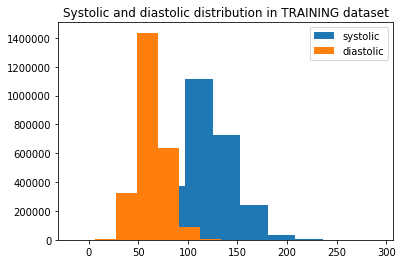

In [0]:
#check sys and dia distribution in train dataset
plt.title("Systolic and diastolic distribution in TRAINING dataset")
plt.hist(train_labels[:,0], label="systolic")
plt.hist(train_labels[:,1],label="diastolic")
plt.legend()

In [0]:
directory = 'D:/WFDB//matched/BP/Cleaned Data/'
val_dir = directory + "validation/val_BP_label*"
val_labels = concatenate_label(val_dir)
val_labels = np.array(val_labels)

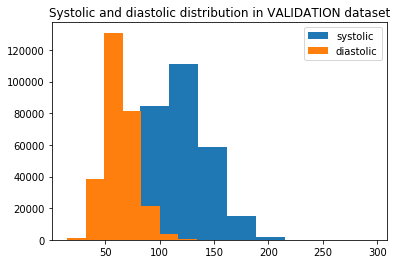

In [0]:
#check sys and dia distribution in validation dataset
plt.title("Systolic and diastolic distribution in VALIDATION dataset")
plt.hist(val_labels[:,0], label="systolic")
plt.hist(val_labels[:,1],label="diastolic")
plt.legend()

In [0]:
directory = 'D:/WFDB//matched/BP/Cleaned Data/'
test_dir = directory + "test/test_BP_label*"
test_labels = concatenate_label(test_dir)
test_labels = np.array(test_labels)

Check the distribution of systolic and diastolic BP value

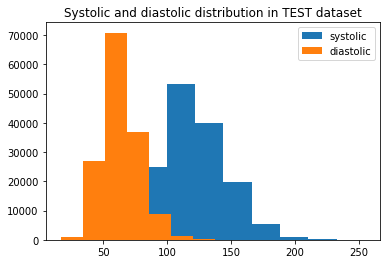

In [0]:
#check sys and dia distribution in test dataset
plt.title("Systolic and diastolic distribution in TEST dataset")
plt.hist(test_labels[:,0], label="systolic")
plt.hist(test_labels[:,1],label="diastolic")
plt.legend()